In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, \
    accuracy_score, \
    f1_score, \
    auc, \
    recall_score, \
    precision_score, \
    precision_recall_curve, \
    roc_curve
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
# Load the dataset
X = np.load('stft.npy')
Z = np.load('mel.npy')
y = np.load('y.npy')

In [10]:
# Encode labels and split the dataset
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, 
                                                    test_size=0.2, 
                                                    stratify=y_encoded)

## Logistic regression on frequency range

In [5]:
# Fit logistic regression model
clf = LogisticRegression(max_iter=2000, solver='lbfgs')
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.8439620081411127
              precision    recall  f1-score   support

        bird       0.80      0.94      0.86       329
         dog       0.93      0.92      0.92       266
        rain       0.79      0.49      0.60       142

    accuracy                           0.84       737
   macro avg       0.84      0.78      0.80       737
weighted avg       0.84      0.84      0.83       737



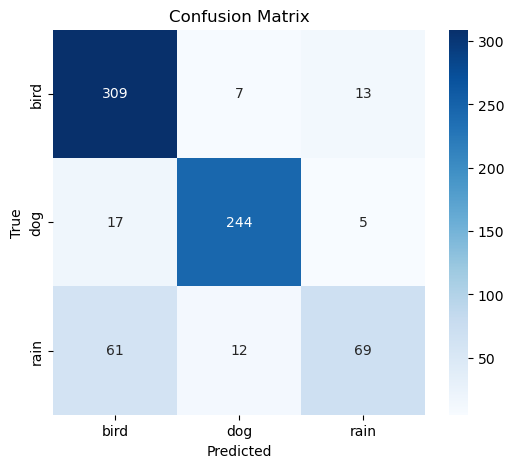

In [6]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## CNN on mel-spectrogram

In [3]:
!nvidia-smi

Mon Jun 23 12:24:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-PCIE-16GB           On  |   00000000:3B:00.0 Off |                    0 |
| N/A   27C    P0             24W /  250W |       4MiB /  16384MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [79]:
class FlexibleCNN(nn.Module):
    """FlexibleCNN: A Convolutional Neural Network for 2D data.
    This model is designed to process audio data represented as spectrograms or sonograms.
    It includes multiple convolutional layers, pooling layers, and fully connected layers.
    """

    def __init__(self, 
                 num_classes,
                 height=32,
                 width=50,
                 kernel_sizes=[3,3,3],
                 padding_sizes=[1,1,1],
                 stride_sizes=[1,1,1],
                 pooling_kernels=[(2,2),(2,2),(2,2)],
                 pooling_strides=[(2,2),(2,2),(2,2)],
                 channel_sizes=[32,16,8], 
                 fc_sizes=[12],
                 activation_layer=nn.ReLU,
                 dropout=0.5,
                 batchNormalization=False, 
                 leakyRelu=False, 
                 ):
        """Initialize the FlexibleCNN model.

        Parameters
        ----------
        num_classes : int
            Number of output classes for classification.
        height : int, optional
            Height of the input spectrogram (default is 32).
        width : int, optional
            Width of the input spectrogram (default is 50).
        kernel_sizes : list of int or tuple, optional
            List of kernel sizes for each convolutional layer.
        padding_sizes : list of int or tuple, optional
            List of padding sizes for each convolutional layer.
        stride_sizes : list of int or tuple, optional
            List of stride sizes for each convolutional layer.
        pooling_kernels : list of int or tuple, optional
            List of pooling kernel sizes for each pooling layer.
        pooling_strides : list of int or tuple, optional
            List of pooling stride sizes for each pooling layer.
        channel_sizes : list of int, optional
            List of output channel sizes for each convolutional layer.
        fc_sizes : list of int, optional
            List of sizes for the fully connected layers.
        activation_layer : callable, optional
            Activation function for the fully connected layers (default is ReLU).
        dropout : float, optional
            Dropout rate for regularization (default is 0.5).
        batchNormalization : bool, optional
            Whether to apply batch normalization after each convolutional layer (default is False).

        Returns
        -------
        None
        """
        super(FlexibleCNN, self).__init__()

        # Validate input parameters
        assert len(kernel_sizes) > 0, "At least one kernel size must be provided"
        ks = kernel_sizes
        ps = padding_sizes
        ss = stride_sizes
        nm = channel_sizes
        pks = pooling_kernels
        pss = pooling_strides
        assert len(ks) == len(ps) == len(ss) == len(nm), \
            "Kernel sizes, padding sizes, stride sizes, and channel sizes must have the same length"
        assert len(pks) == len(pss) == len(nm), \
            "Pooling kernel sizes and pooling stride sizes must match the number of channel sizes" 

        # Define the CNN layers
        cnn = nn.Sequential()
        nIn = 1 # Assuming sonogram input is 1 dimensional
        out_height, out_width = height, width
        for i in range(len(nm)):
            nOut = nm[i]
            # Add a convolutional layer
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            # Calculate output height and width after this conv layer
            out_height = (out_height + 2 * ps[i] - ks[i]) // ss[i] + 1
            out_width = (out_width + 2 * ps[i] - ks[i]) // ss[i] + 1

            # Add batch normalization if specified
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))

            # Add activation function
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

            # Add the pooling layer
            pooling_kernel = pooling_kernels[i]
            pooling_stride = pooling_strides[i]
            cnn.add_module('pooling{0}'.format(i), nn.MaxPool2d(pooling_kernel, pooling_stride))
            # Update output height and width after pooling
            out_height = (out_height - pooling_kernel[0]) // pooling_stride[0] + 1
            out_width = (out_width - pooling_kernel[1]) // pooling_stride[1] + 1

            # Add dropout if specified
            if dropout > 0:
                cnn.add_module('dropout{0}'.format(i), nn.Dropout(dropout))

            # Update input channels for the next layer
            nIn = nOut

        # Save the CNN layers and output dimensions
        self.cnn = cnn
        self.height = out_height
        self.width = out_width

        # Define the fully connected layers
        dnn = nn.Sequential()
        dnn.add_module('fc1', nn.Linear(nm[-1] * out_height * out_width, 
                                        fc_sizes[0]
                                        ))
        dnn.add_module('fc_activation', activation_layer())
        for _ in range(1,len(fc_sizes)):
            dnn.add_module('fc{0}'.format(_+1), nn.Linear(fc_sizes[_-1], fc_sizes[_]))
            dnn.add_module('fc_activation{0}'.format(_+1), activation_layer())
        dnn.add_module('fc-1', nn.Linear(fc_sizes[-1], num_classes))
        self.fcnn = dnn

    def forward(self, x):
        """Forward pass of the SchMichiganCNN model.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (batch_size, in_channels, height, width).

        Returns
        -------
        torch.Tensor
            Output tensor of shape (batch_size, num_classes).
        """
        x = self.cnn(x)
        x = x.view(x.size(0), -1) # x.size(0) is the batch size
        x = self.fcnn(x)
        return x

In [11]:
# Split the data into training and testing sets
w = torch.tensor(y_encoded, dtype=torch.long)
Z_tensor = torch.tensor(Z, dtype=torch.float32)
Z_train, Z_test, w_train, w_test = train_test_split(
    Z_tensor, w, test_size=0.2, stratify=y_encoded, random_state=42
)

In [12]:
batch_size = 200
train_data = TensorDataset(Z_train, w_train)
test_data = TensorDataset(Z_test, w_test)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [97]:
model = FlexibleCNN(num_classes=len(le.classes_),
                       height=Z.shape[1],
                       width=Z.shape[2],
                         kernel_sizes=[3,3,3],
                         padding_sizes=[1,1,1],
                         stride_sizes=[1,1,1],
                         pooling_kernels=[(2,2),(2,2),(2,2)],
                         pooling_strides=[(2,2),(2,2),(2,2)],
                         channel_sizes=[64,32,16], 
                         fc_sizes=[32,32],
                       )

In [98]:
if type(model) == FlexibleCNN:
    conv_params = 0
    fc_params = 0

    for name, param in model.named_parameters():
        if 'conv' in name:
            conv_params += param.numel()
        elif 'fc' in name:
            fc_params += param.numel()

    print(f"Total Conv2d parameters: {conv_params}")
    print(f"Total Fully Connected (Linear) parameters: {fc_params}")
    print()


Total Conv2d parameters: 23728
Total Fully Connected (Linear) parameters: 435363



In [99]:
model

FlexibleCNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (dropout0): Dropout(p=0.5, inplace=False)
    (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (dropout1): Dropout(p=0.5, inplace=False)
    (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (dropout2): Dropout(p=0.5, inplace=False)
  )
  (fcnn): Sequential(
    (fc1): Linear(in_features=13568, out_features=32, bias=True)
    (fc_activation): ReLU()
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc_acti

In [100]:
# Example usage

num_epochs = 50  # Number of epochs to train

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification

# Choose an optimizer for training
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # You can adjust the learning rate


In [101]:
# # Training loop

model.to(device)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:

        # Zero the parameter gradients
        optimizer.zero_grad()
        inputs = inputs.unsqueeze(1)

        # Pass to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1/50, Loss: 0.7382
Epoch 2/50, Loss: 0.5702
Epoch 3/50, Loss: 0.5066
Epoch 4/50, Loss: 0.4767
Epoch 5/50, Loss: 0.4329
Epoch 6/50, Loss: 0.4368
Epoch 7/50, Loss: 0.4067
Epoch 8/50, Loss: 0.3972
Epoch 9/50, Loss: 0.3792
Epoch 10/50, Loss: 0.3898
Epoch 11/50, Loss: 0.3884
Epoch 12/50, Loss: 0.3578
Epoch 13/50, Loss: 0.3496
Epoch 14/50, Loss: 0.3461
Epoch 15/50, Loss: 0.3453
Epoch 16/50, Loss: 0.3168
Epoch 17/50, Loss: 0.3119
Epoch 18/50, Loss: 0.3094
Epoch 19/50, Loss: 0.3445
Epoch 20/50, Loss: 0.2887
Epoch 21/50, Loss: 0.2668
Epoch 22/50, Loss: 0.2501
Epoch 23/50, Loss: 0.2449
Epoch 24/50, Loss: 0.2547
Epoch 25/50, Loss: 0.2563
Epoch 26/50, Loss: 0.2473
Epoch 27/50, Loss: 0.2995
Epoch 28/50, Loss: 0.2583
Epoch 29/50, Loss: 0.2434
Epoch 30/50, Loss: 0.2349
Epoch 31/50, Loss: 0.2580
Epoch 32/50, Loss: 0.2319
Epoch 33/50, Loss: 0.2165
Epoch 34/50, Loss: 0.2142
Epoch 35/50, Loss: 0.2125
Epoch 36/50, Loss: 0.2044
Epoch 37/50, Loss: 0.2367
Epoch 38/50, Loss: 0.2312
Epoch 39/50, Loss: 0.

In [102]:
# torch.save(model, "large_cnn.pth")
# torch.save(model, "small_cnn.pth")
# torch.save(model, "more_fcs.pth")
torch.save(model, "biggest_model.pth")

In [103]:
# model = torch.load("large_cnn.pth", weights_only=False)
# model = torch.load("small_cnn.pth", weights_only=False)
# model = torch.load("more_fcs.pth", weights_only=False)
model = torch.load("biggest_model.pth", weights_only=False)

In [104]:
model.to(device)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(all_labels, all_preds, target_names=le.classes_))

Validation Accuracy: 0.9132
              precision    recall  f1-score   support

        bird       0.87      0.96      0.91       329
         dog       0.99      0.94      0.96       266
        rain       0.90      0.75      0.82       142

    accuracy                           0.91       737
   macro avg       0.92      0.88      0.90       737
weighted avg       0.92      0.91      0.91       737



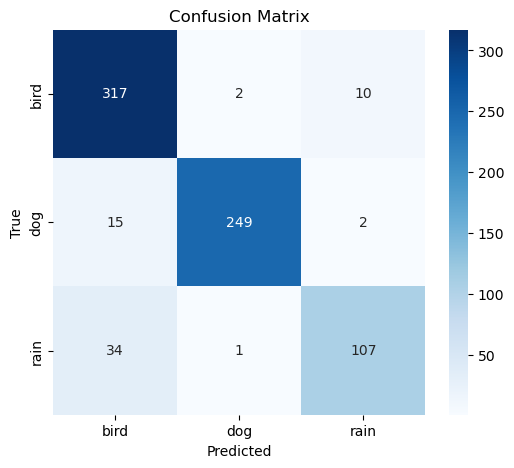

In [105]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()